In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

Load Data

In [2]:
# Load Data
data = pd.read_csv("AirQuality.csv", index_col=False)
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
# data = data.asfreq('M')
data = data.sort_values("Date").set_index("Date")
df = data[data['County'] == 'Utah']
df= df.loc[~df.index.duplicated(keep='first')]

# Train-Test-Split
Z = df["AQI"] 
# Randomly chosen subsection of the data
Z = Z[1000:1200]
train_size = int(len(Z) * 0.8)
train, test = Z[:train_size], Z[train_size:]

Stationary Test

In [3]:
# Extract AQI column
series = df['AQI']

# Run ADF test
result = adfuller(series)
print(f"ADF Statistic: {result[0]}")
print(f'p-value: {result[1]:.10f}')
if (result[1] < 0.05):
    print("Data is Stationary")

ADF Statistic: -7.592408393570254
p-value: 0.0000000000
Data is Stationary


Choosing Model Parameters

In [4]:
###### ARIMA Parameters ######

# Define the p, d, q ranges (feel free to expand if needed)
d = [0]
p = q = range(0, 3)  # try values 0 through 3
pdq = list(itertools.product(p, d, q))

# Store the best model info
best_aic = np.inf
best_order = None
best_model = None

# Grid search through all combinations
for order in pdq:
    try:
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        current_aic = model_fit.aic

        if current_aic < best_aic:
            best_aic = current_aic
            best_order = order
            best_model = model_fit
        
    except Exception as e:
        # Skip invalid models
        continue

print("\nBest ARIMA Model:")
print(f"Order: {best_order}, AIC: {best_aic:.2f}")



Best ARIMA Model:
Order: (2, 0, 2), AIC: 29033.55


In [5]:
###### SARIMA Parameters ######

# Define the parameter grid (adjust ranges based on your data)
d = [0]
p = q = range(0, 3)  # AR, differencing, and MA terms
P = D = Q = range(0, 3)  # Seasonal AR, differencing, and SMA terms
S = [12]  # Seasonal period for monthly data with yearly seasonality (e.g., 12 for monthly)

# Generate all possible combinations of parameters
param_grid = list(itertools.product(p, d, q, P, D, Q, S))

# Loop through the grid and fit the SARIMA model
best_aic = np.inf
best_params = None

for param in param_grid:
    try:
        model = SARIMAX(series, order=(param[0], param[1], param[2]), 
                        seasonal_order=(param[3], param[4], param[5], param[6]))
        results = model.fit(disp=False)
        
        # Store the best AIC and parameters
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue


print("\nBest SARIMA Model:")
print(f"Order: {best_params[:3]}, Seasonal Order: {best_params[3:7]}, AIC: {best_aic:.2f}")


Best SARIMA Model:
Order: (2, 0, 2), Seasonal Order: (0, 1, 2, 12), AIC: 29005.07


ARIMA/SARIMA Modeling

In [15]:
def forecast(model, params, series_name, ARIMA=True):

    # Get in-sample predictions (fitted values)
    fitted_model = model.fit()
    fitted_values = fitted_model.fittedvalues

    # Forecast the test period
    forecast = fitted_model.forecast(steps=len(test))

    # Plot data, fitted values, forecasted values
    plt.figure(figsize=(12,6))
    # plt.figure(dpi=200)
    plt.plot(Z, label="Original Data")
    plt.plot(test.index, forecast, label="Forecast", color="g")
    plt.axvline(x=test.index[0], color="gray", label="Train-Test Split", linestyle="dashed")
    plt.plot(fitted_values, label="Fitted Values", color='orange')
    # Display
    if ARIMA:
        plt.title(f"ARIMA Model({params}): {series_name}")
    else:
        plt.title(f"SARIMA Model(2, 0, 2)x(0, 1, 2, 12): {series_name}")
    plt.xlabel("Time (Daily)")
    plt.ylabel("AQI Value")
    plt.legend()
    plt.show()

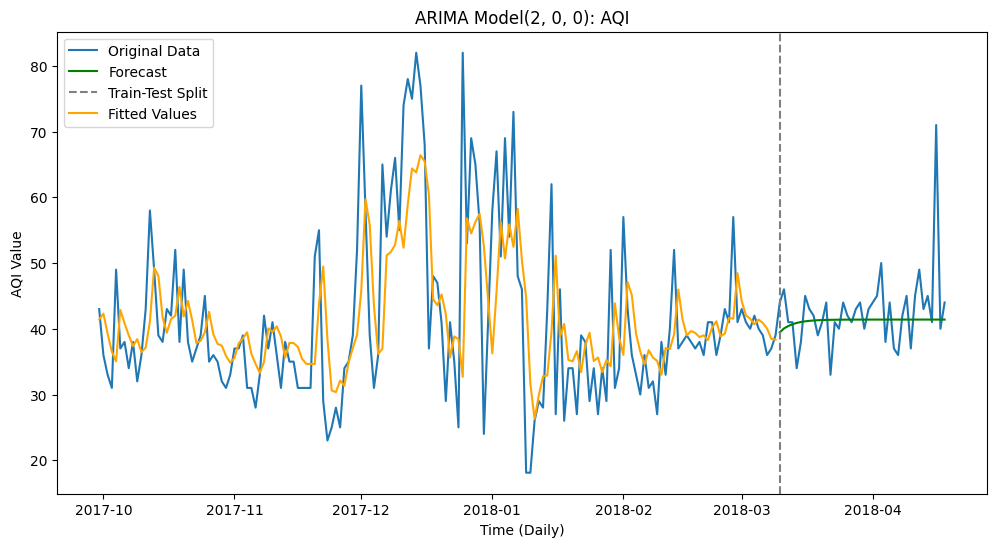

In [11]:
# ARIMA Model
p, d, q = 2, 0, 0
params = ", ".join(map(str,(p,d,q)))
model = ARIMA(train, order=(p, d, q))
forecast(model, params, "AQI")

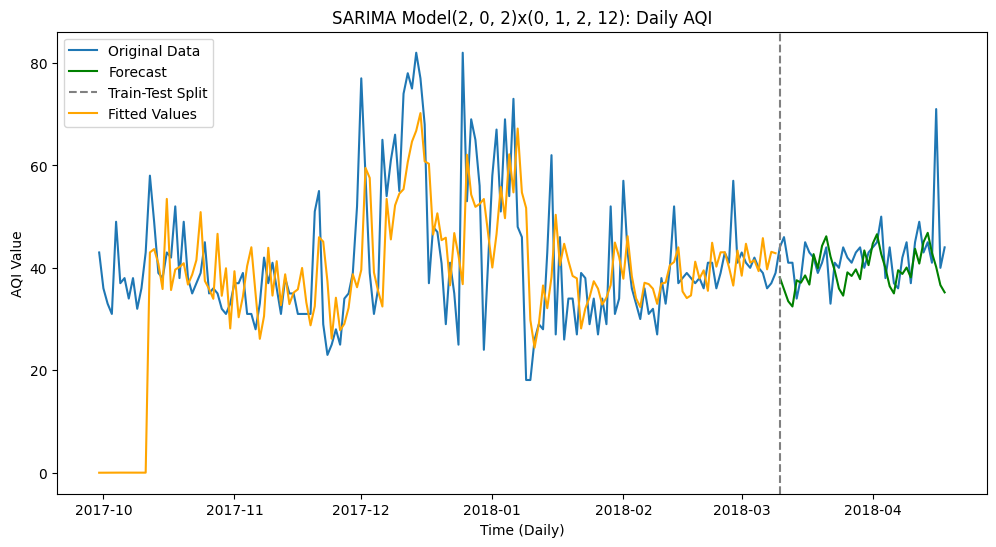

In [17]:
# SARIMA model
p, d, q, P, D, Q, s = 2, 0, 2, 0, 1, 2, 12
params = ", ".join(map(str,(p,d,q)))
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
forecast(model, params, "Daily AQI", False)

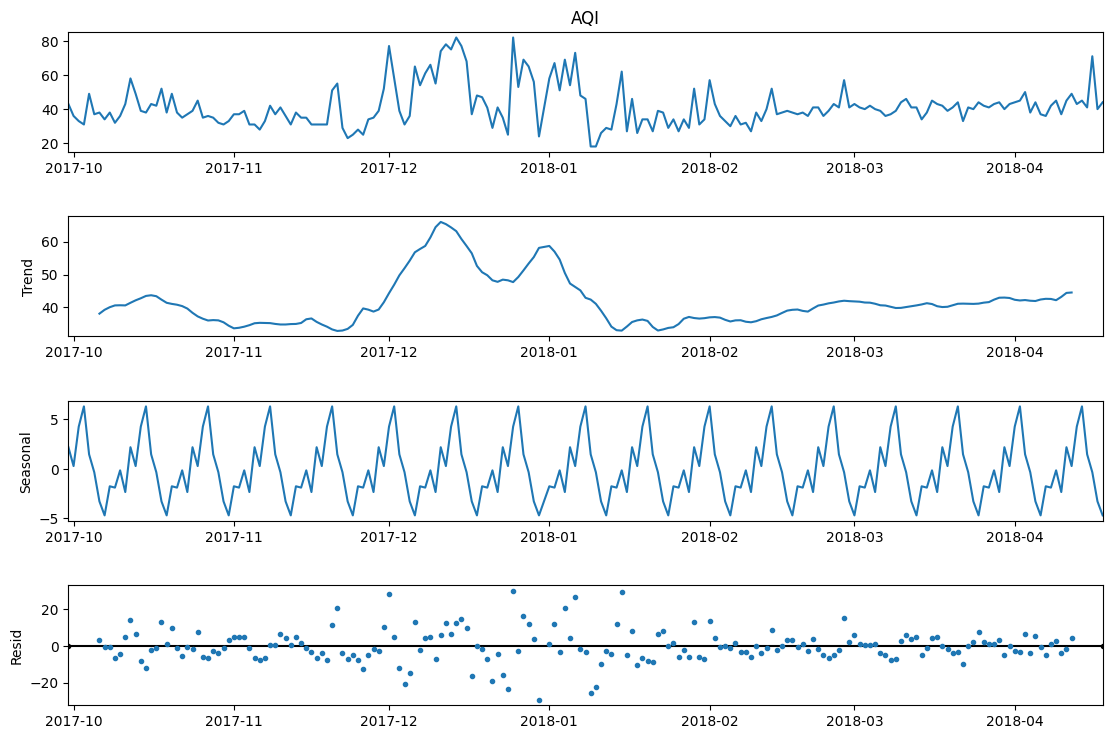

In [9]:
# Decompose the time series
decomposition = seasonal_decompose(Z, period=12)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
# Access the residual plot and adjust the dot size
residual_axes = fig.axes[3]  # Residual plot is the 4th one
for line in residual_axes.lines:
    line.set_marker('o')  # Set the marker type to circle
    line.set_markersize(3)  # Set smaller marker size (adjust as needed)

plt.show()